In [1]:
!pip install pytesseract
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = glob('../content/drive/MyDrive/inputnumber-plate-detection/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [4]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,../content/drive/MyDrive/inputnumber-plate-det...,31,139,128,161
1,../content/drive/MyDrive/inputnumber-plate-det...,164,316,216,243
2,../content/drive/MyDrive/inputnumber-plate-det...,1093,1396,645,727
3,../content/drive/MyDrive/inputnumber-plate-det...,813,1067,665,724
4,../content/drive/MyDrive/inputnumber-plate-det...,134,301,312,350


In [5]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('../content/drive/MyDrive/inputnumber-plate-detection/images',filename_image)
    return filepath_image
getFilename(filename)

'../content/drive/MyDrive/inputnumber-plate-detection/images/N101.jpeg'

In [6]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['../content/drive/MyDrive/inputnumber-plate-detection/images/N101.jpeg',
 '../content/drive/MyDrive/inputnumber-plate-detection/images/N102.jpeg',
 '../content/drive/MyDrive/inputnumber-plate-detection/images/N1.jpeg',
 '../content/drive/MyDrive/inputnumber-plate-detection/images/N103.jpeg',
 '../content/drive/MyDrive/inputnumber-plate-detection/images/N100.jpeg',
 '../content/drive/MyDrive/inputnumber-plate-detection/images/N105.jpeg',
 '../content/drive/MyDrive/inputnumber-plate-detection/images/N109.jpeg',
 '../content/drive/MyDrive/inputnumber-plate-detection/images/N116.jpeg',
 '../content/drive/MyDrive/inputnumber-plate-detection/images/N11.jpeg',
 '../content/drive/MyDrive/inputnumber-plate-detection/images/N106.jpeg']

In [7]:
file_path = image_path[87] #path of our image N2.jpeg
img = cv2.imread(file_path)
# xmin-1804/ymin-1734/xmax-2493/ymax-1882
img = io.imread(file_path)
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=1804, x1=2493, y0=1734, y1=1882, xref='x', yref='y',line_color='cyan')

In [8]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [9]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [10]:
# Split the data into training and testing
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

In [11]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))

headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)

model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

TRAINING

In [13]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=280,
                    validation_data=(x_test,y_test))

Epoch 1/280


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(10, 224, 224, 3))



18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.0619

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))



18/18 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - loss: 0.0612 - val_loss: 0.0465
Epoch 2/280
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.0155 - val_loss: 0.0214
Epoch 3/280
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - loss: 0.0103 - val_loss: 0.0183
Epoch 4/280
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 0.0083 - val_loss: 0.0166
Epoch 5/280
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.0059 - val_loss: 0.0125
Epoch 6/280
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - loss: 0.0039 - val_loss: 0.0108
Epoch 7/280
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.0028 - val_loss: 0.0111
Epoch 8/280
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - loss: 0.0025 - val_loss: 0.0112
Epoch 9/280
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - loss: 0.0024 - val_loss: 0.0111
Epoch 10/280
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - loss: 0.0024 - val_loss: 0.0128
Epoch 11/280
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - loss: 0.0024 - val_loss: 0.0113
Epoch 12/280
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step 

In [14]:
# Save model using the recommended .keras format
model.save('./Number_Plate_detection.keras')
print('Model saved successfully in .keras format')


Model saved successfully in .keras format


In [15]:
path = '../content/drive/MyDrive/inputnumber-plate-detection/images/N1.jpeg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)


Height of the image = 1080
Width of the image = 1920


In [16]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10))

Output hidden; open in https://colab.research.google.com to view.

In [17]:
image_arr_224.shape

(224, 224, 3)

In [18]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [19]:
# Make predictions
coords = model.predict(test_arr)
coords

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))



1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


array([[0.57425815, 0.7258839 , 0.5991478 , 0.66736406]], dtype=float32)

In [20]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[1102.57564545, 1393.69709015,  647.07962036,  720.75318575]])

In [21]:
coords = coords.astype(np.int32)
coords

array([[1102, 1393,  647,  720]], dtype=int32)

In [22]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(1102, 647) (1393, 720)


In [23]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

Output hidden; open in https://colab.research.google.com to view.

TESTING

In [24]:
path = '../content/drive/MyDrive/inputnumber-plate-detection/TEST/TEST.jpeg'
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(228,228))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,228,228,3)

    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, None, None, 3))



1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
(340, 482) (588, 545)


In [25]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
output_path = "output_image.jpg"
cv2.imwrite(output_path, roi)

True

(-0.5, 247.5, 62.5, -0.5)

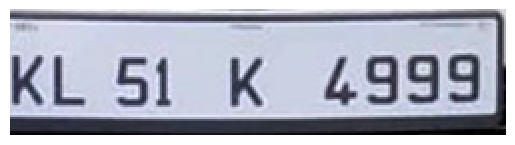

In [26]:
plt.imshow(roi)
plt.axis('off')

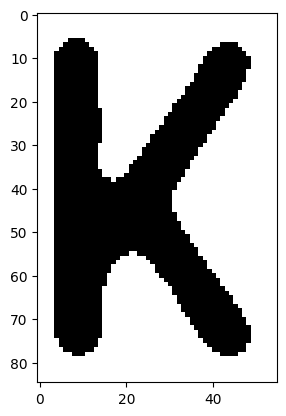

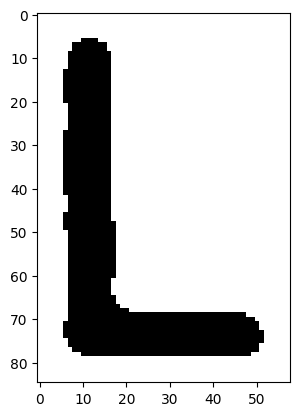

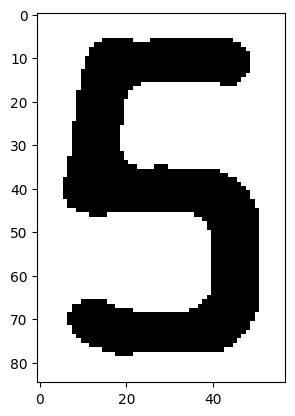

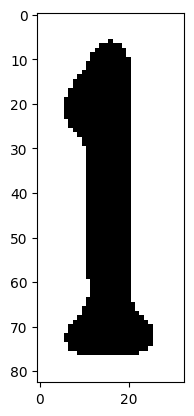

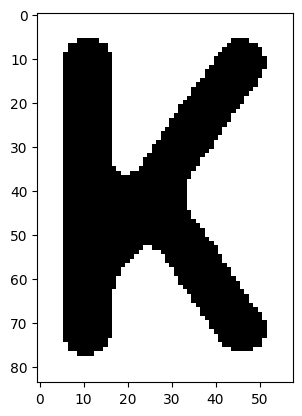

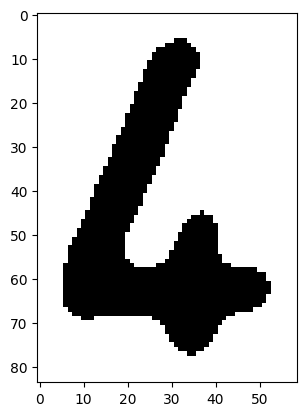

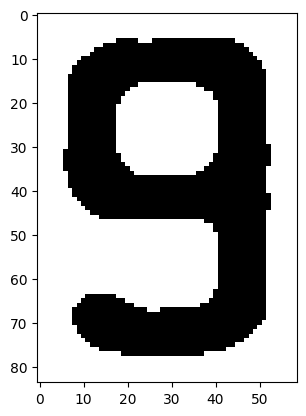

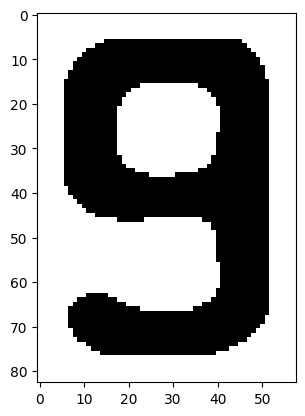

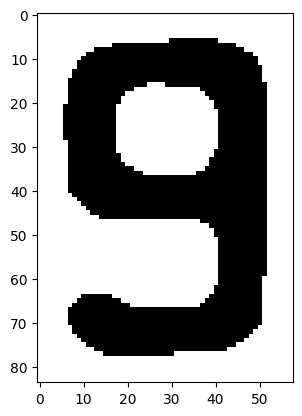

In [27]:
import cv2
import numpy as np

# Load the image in grayscale
gray = cv2.imread("/content/output_image.jpg", 0)
if gray is None:
    raise FileNotFoundError("The specified image path is invalid.")

# Resize the image
gray = cv2.resize(gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)

# Apply Gaussian and median blurring
blur = cv2.GaussianBlur(gray, (5, 5), 0)
gray = cv2.medianBlur(blur, 3)

# Apply Otsu's thresholding (binary inverse for better contour detection)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Define a rectangular kernel for morphological operations
rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Apply dilation to enhance contours
dilation = cv2.dilate(thresh, rect_kern, iterations=1)

# Find contours (updated to handle both OpenCV 3.x and 4.x versions)
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours left-to-right based on x-coordinate of the bounding box
sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

# Reload the original image for drawing rectangles and extracting ROIs
im2 = cv2.imread("/content/output_image.jpg")
if im2 is None:
    raise FileNotFoundError("The specified image path is invalid.")

roi_list = []

# Loop over contours and filter them based on size and aspect ratio
for cnt in sorted_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    height, width = im2.shape[:2]

    # Filter conditions for number plate regions
    if height / float(h) > 6:  # Height filter
        continue
    ratio = h / float(w)
    if ratio < 1.5:  # Aspect ratio filter
        continue
    area = h * w
    if width / float(w) > 15:  # Width filter
        continue
    if area < 100:  # Area filter
        continue

    # Draw rectangle around the detected region
    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Extract the region of interest and process it
    roi = thresh[max(y-5, 0):y + h + 5, max(x-5, 0):x + w + 5]
    roi = cv2.bitwise_not(roi)
    roi = cv2.medianBlur(roi, 5)
    roi_list.append(roi)

# Convert the list of ROIs to a NumPy array
for roi in roi_list:
    # Example: Display the ROI using matplotlib
    import matplotlib.pyplot as plt
    plt.imshow(roi, cmap='gray')
    plt.show()



Visualization

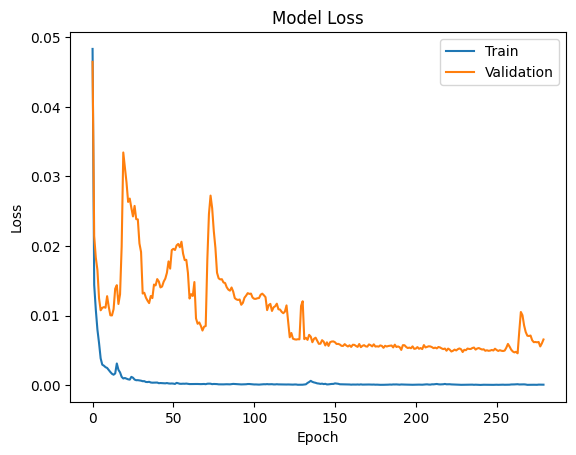

In [28]:
#Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

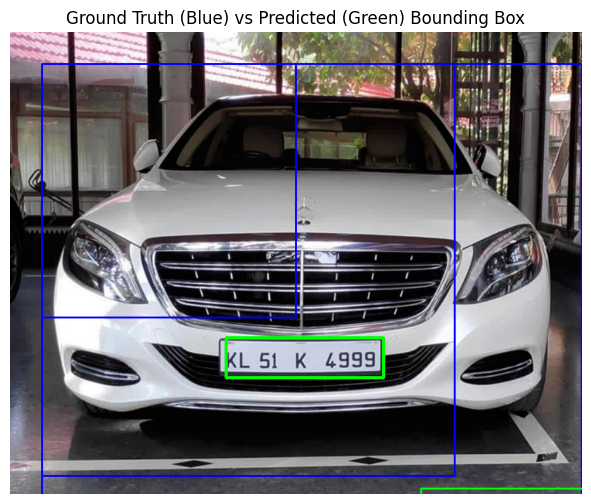

In [38]:
#ground truth coordinates for the test image
gt_xmin, gt_ymin, gt_xmax, gt_ymax = 50, 50, 900, 900

# Predicted coordinates from the model
pred_xmin, pred_ymin, pred_xmax, pred_ymax = coords[0]

# Draw ground truth bounding box (in blue) and predicted bounding box (in green)
cv2.rectangle(image, (gt_xmin, gt_ymin), (gt_xmax, gt_ymax), (0, 0, 255), 2)
cv2.rectangle(image, (pred_xmin, pred_ymin), (pred_xmax, pred_ymax), (0, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title("Ground Truth (Blue) vs Predicted (Green) Bounding Box")
plt.axis('off')
plt.show()
